[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sat May 31 17:12:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 85%   58C    P0             61W /  170W |    3027MiB /  12288MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [10]:
import os
HOME = os.getcwd()
print(HOME)

c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references


## Install YOLO11 via Ultralytics

In [4]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40  Python-3.9.1 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Setup complete  (8 CPUs, 63.9 GB RAM, 1727.2/1861.7 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [5]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

Ultralytics 8.3.40 🚀 Python-3.9.1 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 84.6ms
Speed: 6.0ms preprocess, 84.6ms inference, 190.6ms postprocess per image at shape (1, 3, 640, 384)
Results saved to c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\runs\detect\predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

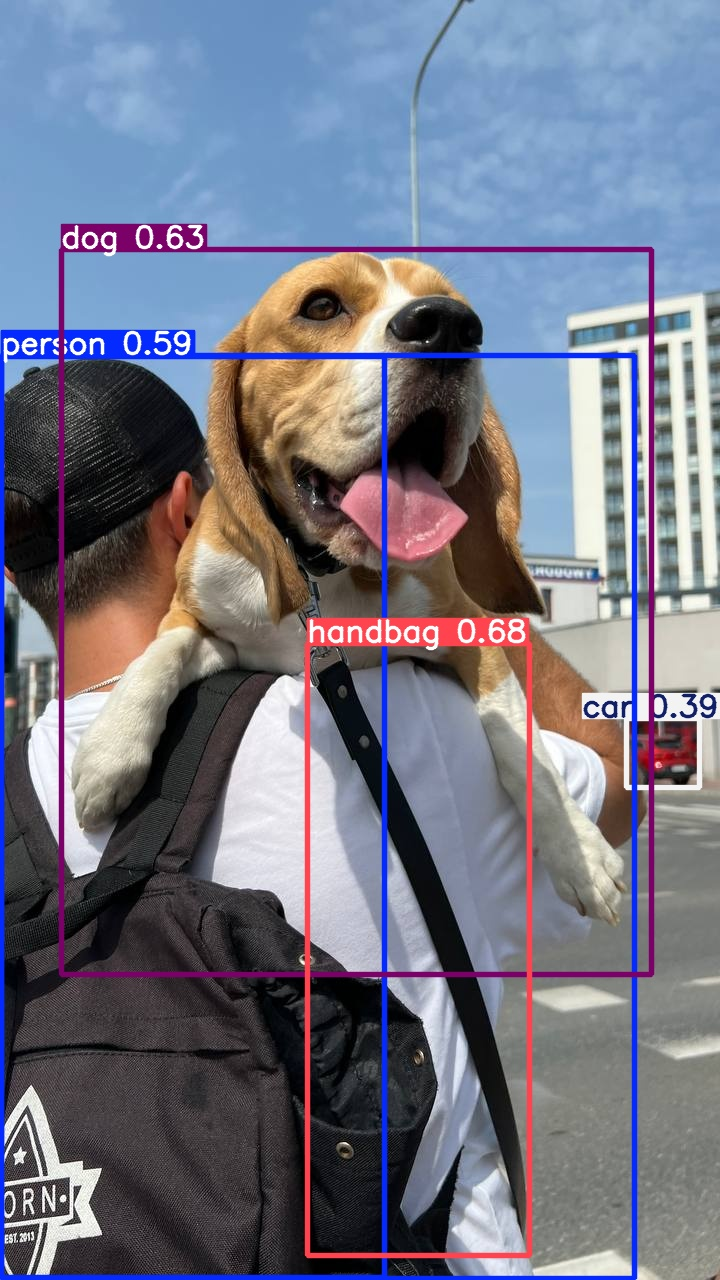

In [6]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'C:/Users/SABIO/Documents/GitHub/Pool-Detection-CNN/references/runs/detect/predict/dog.jpg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [2]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 68.5ms
Speed: 4.1ms preprocess, 68.5ms inference, 87.9ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [3]:
result.boxes.xyxy

tensor([[3.0705e+02, 6.4337e+02, 5.2917e+02, 1.2560e+03],
        [6.1386e+01, 2.4994e+02, 6.5166e+02, 9.7413e+02],
        [1.7837e+00, 3.5550e+02, 6.3406e+02, 1.2788e+03],
        [1.1974e+00, 3.5620e+02, 3.8464e+02, 1.2776e+03],
        [6.2617e+02, 7.1818e+02, 6.9975e+02, 7.8753e+02]], device='cuda:0')

In [4]:
result.boxes.conf

tensor([0.6823, 0.6283, 0.5945, 0.3924, 0.3869], device='cuda:0')

In [5]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [6]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

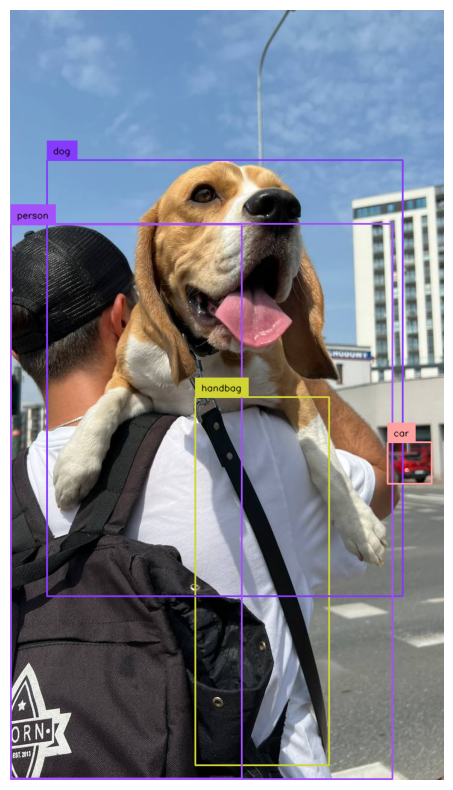

In [7]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [11]:
from dotenv import load_dotenv
import os

env_path = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.env"
load_dotenv(dotenv_path=env_path)
robo_token = os.getenv("ROBOFLOW_API_KEY")

!mkdir {HOME}/datasets
%cd {HOME}/datasets

#from google.colab import userdata
from roboflow import Roboflow



from roboflow import Roboflow
rf = Roboflow(api_key=robo_token)
project = rf.workspace("spencer-kmi6v").project("pool-detect-cnn")
version = project.version(2)
dataset = version.download("yolov11")
                

[WinError 2] The system cannot find the file specified: 'c:\\Users\\SABIO\\Documents\\GitHub\\Pool-Detection-CNN\\references/datasets'
c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references
loading Roboflow workspace...


The syntax of the command is incorrect.


loading Roboflow project...



Extracting Dataset Version Zip to Pool-Detect-CNN-2 in yolov11:: 100%|██████████| 590/590 [00:00<00:00, 1603.35it/s]


## Custom Training

In [22]:
#%cd {HOME}
import os

HOME = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references"
os.chdir(HOME)

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 plots=True

New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.9.1 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nm


train: Scanning C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2\train\labels.cache... 202 images, 64 backgrounds, 0 corrupt: 100%|██████████| 202/202 [00:00<?, ?it/s]
train: Scanning C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2\train\labels.cache... 202 images, 64 backgrounds, 0 corrupt: 100%|██████████| 202/202 [00:00<?, ?it/s]

val: Scanning C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2\valid\labels.cache... 58 images, 30 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]
val: Scanning C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2\valid\labels.cache... 58 images, 30 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]
      1/100      4.15G      1.709      6.927      1.761         41        640:   0%|          | 0/13 [00:00<?, ?it/s]
      1/100      4.15G      1.709      6.927      1.76

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [23]:
import os

HOME = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\runs\detect\train"
for file in os.listdir(HOME):
    print(file)

args.yaml
confusion_matrix.png
confusion_matrix_normalized.png
F1_curve.png
labels.jpg
labels_correlogram.jpg
PR_curve.png
P_curve.png
results.csv
results.png
R_curve.png
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
weights


In [15]:
!ls {HOME}/runs/detect/train/

'ls' is not recognized as an internal or external command,
operable program or batch file.


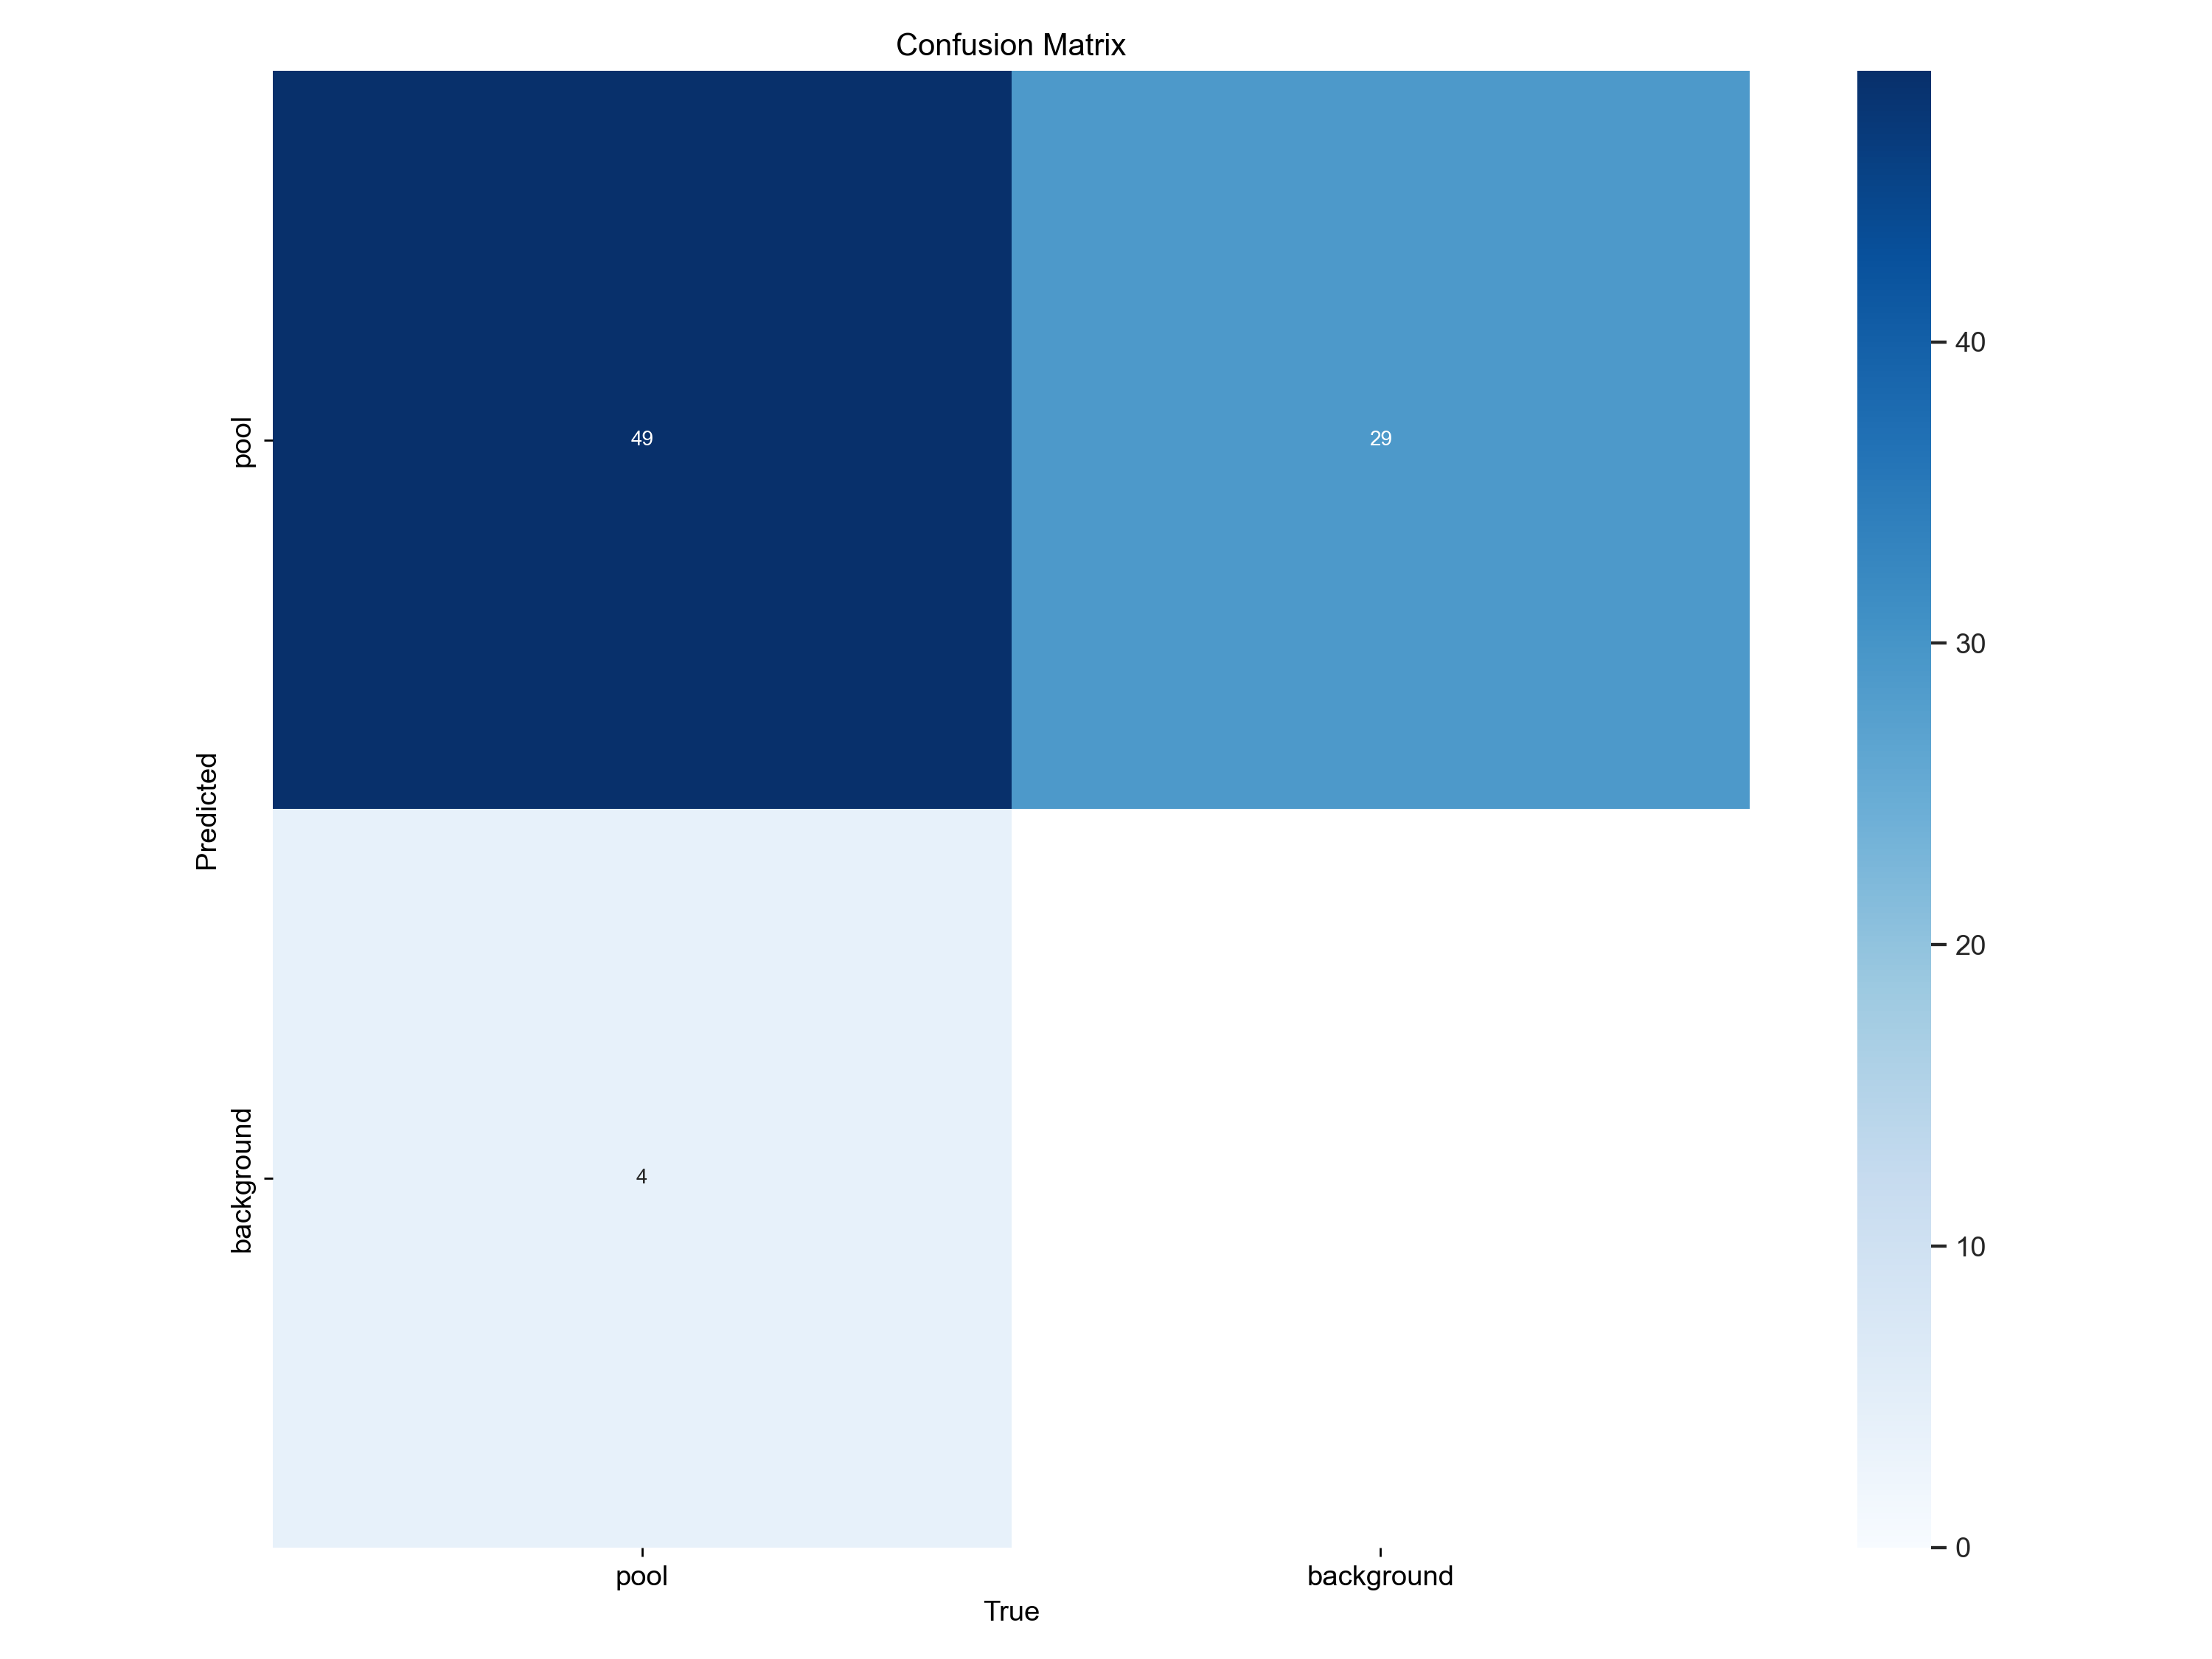

In [24]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'../runs/detect/train/confusion_matrix.png', width=600)

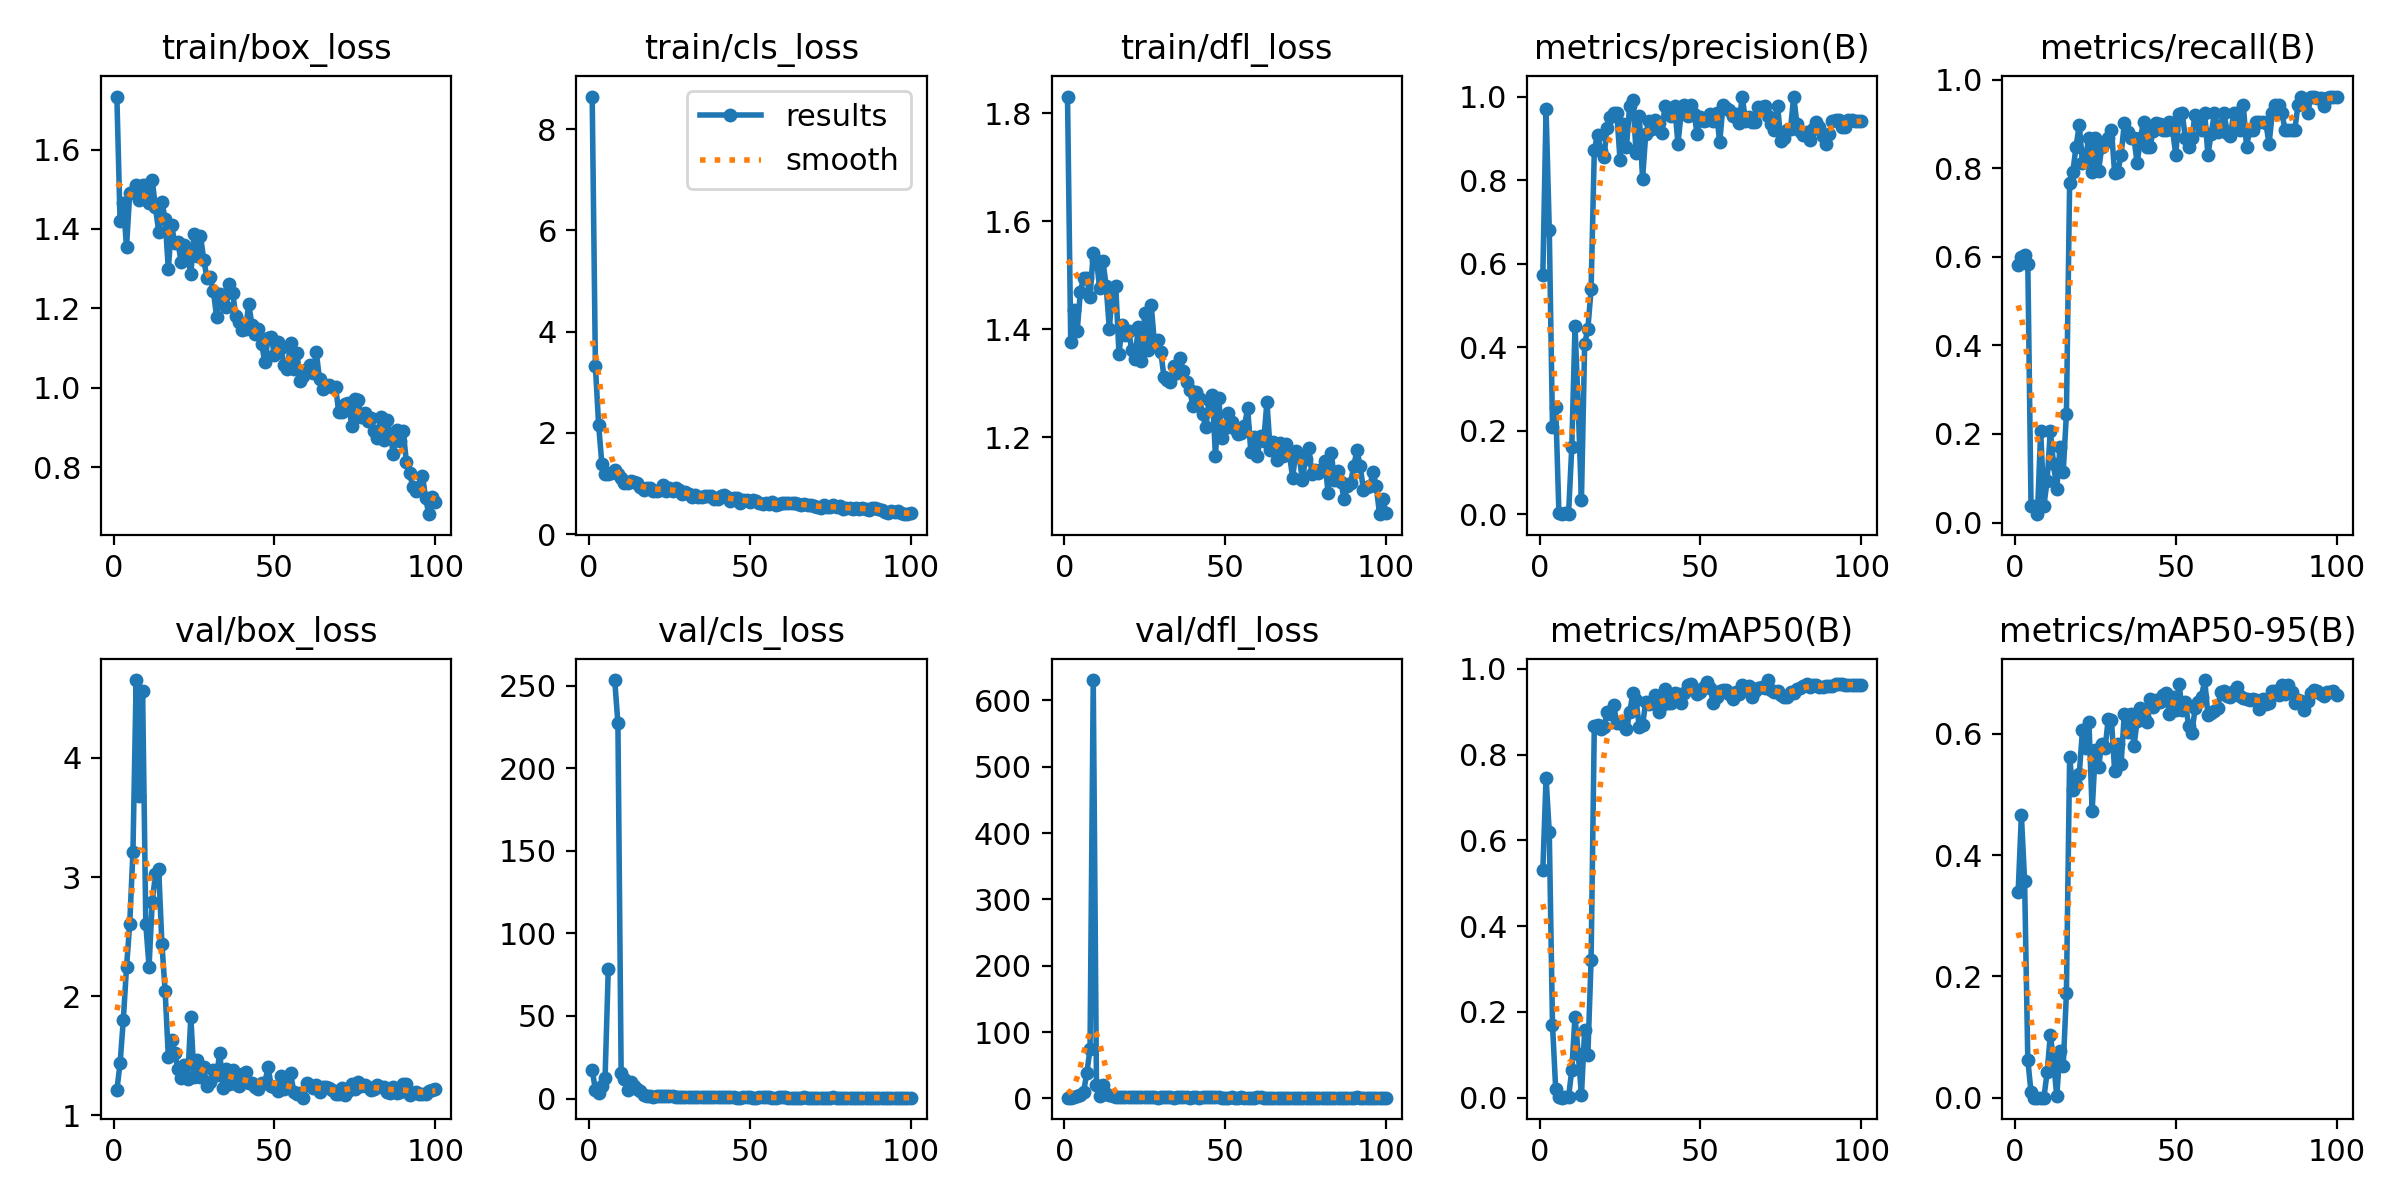

In [25]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'../runs/detect/train2/results.png', width=600)

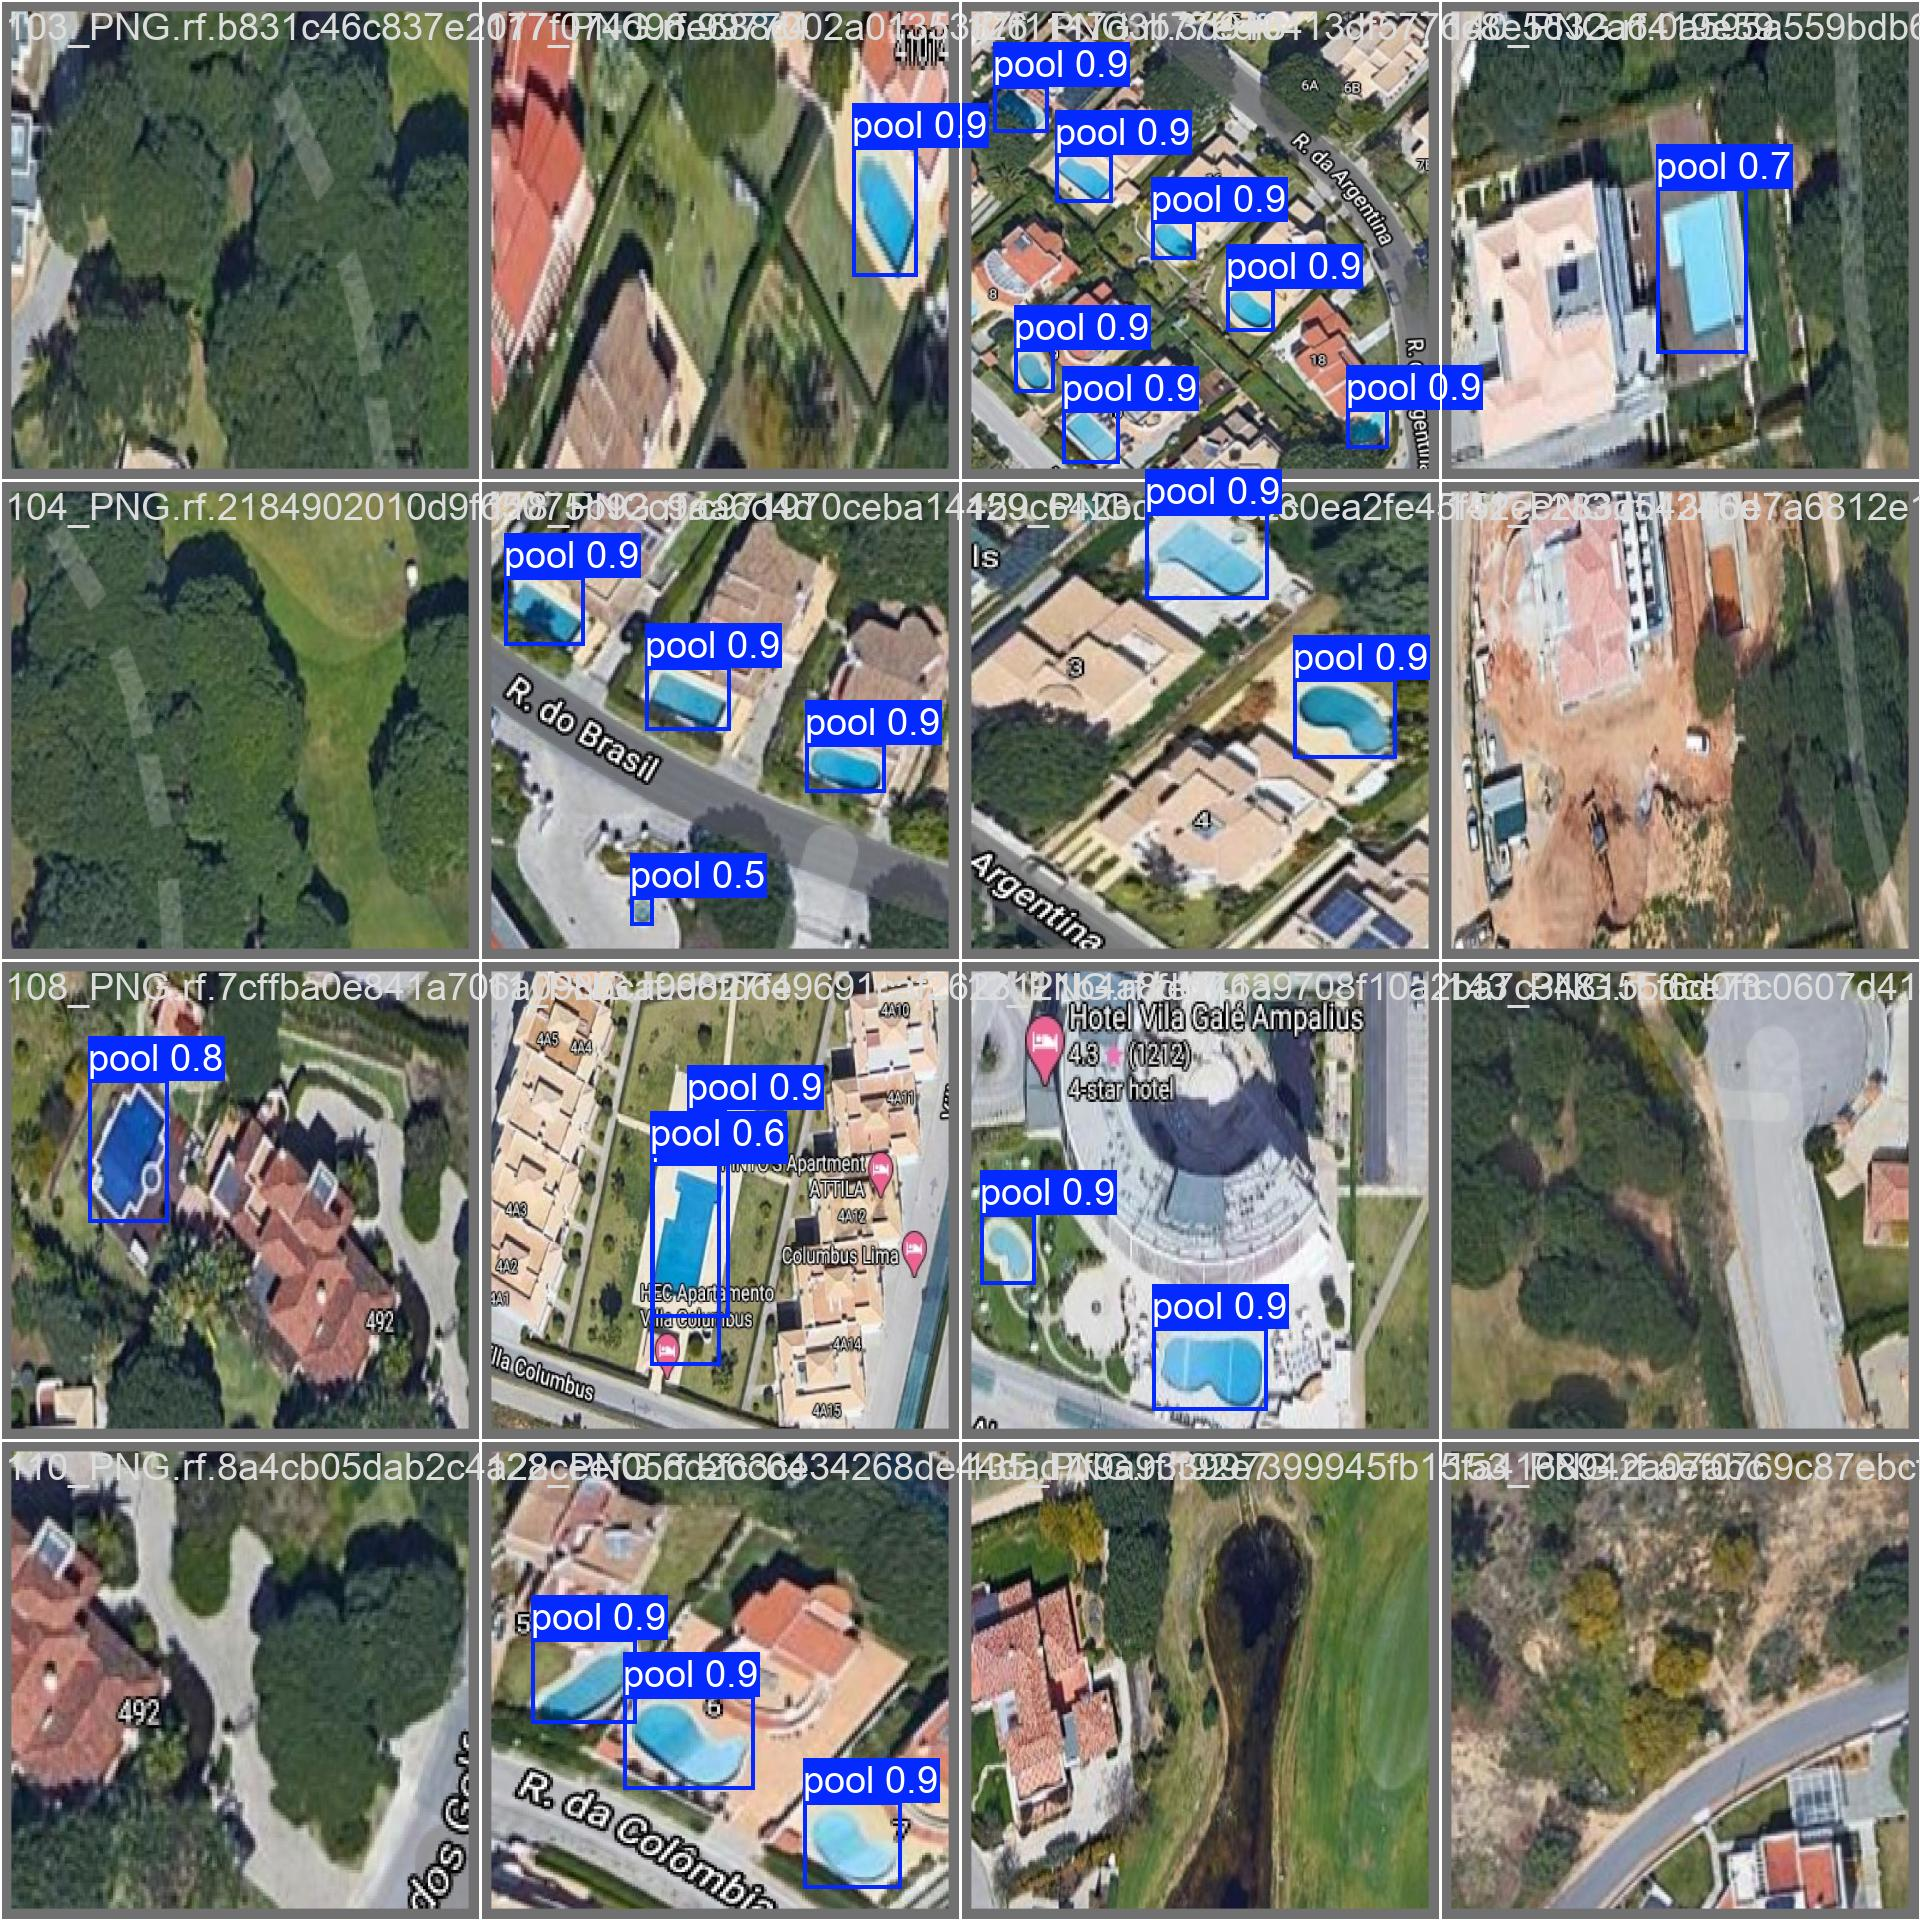

In [26]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'../runs/detect/train2/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [29]:
!yolo task=detect mode=val model=../runs/detect/train2/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.9.1 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
                   all         58         53      0.968      0.925      0.942      0.682
Speed: 1.7ms preprocess, 9.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\runs\detect\val2
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2\valid\labels.cache... 58 images, 30 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]
val: Scanning C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2\valid\labels.cache... 58 images, 30 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:03<00:09,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:03<00:02,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:03<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mA

## Inference with custom model

In [30]:
!yolo task=detect mode=predict model=../runs/detect/train2/weights/best.pt conf=0.5 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.9.1 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/29 c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2\test\images\100_PNG.rf.ffdef2d2973836d984e179774e12de86.jpg: 640x640 2 pools, 14.0ms
image 2/29 c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2\test\images\109_PNG.rf.aa422e1fdcc7b5d65d43a8421bffe770.jpg: 640x640 1 pool, 13.2ms
image 3/29 c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2\test\images\111_PNG.rf.9b45c26604f5c59c4219cd5543aa56be.jpg: 640x640 (no detections), 11.3ms
image 4/29 c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2\test\images\127_PNG.rf.81e460b19419b9d1a527cb40a9a89179.jpg: 640x640 1 pool, 14.8ms
image 5/29 c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\Pool-Detect-CNN-2\test\images\128_PNG

**NOTE:** Let's take a look at few results.

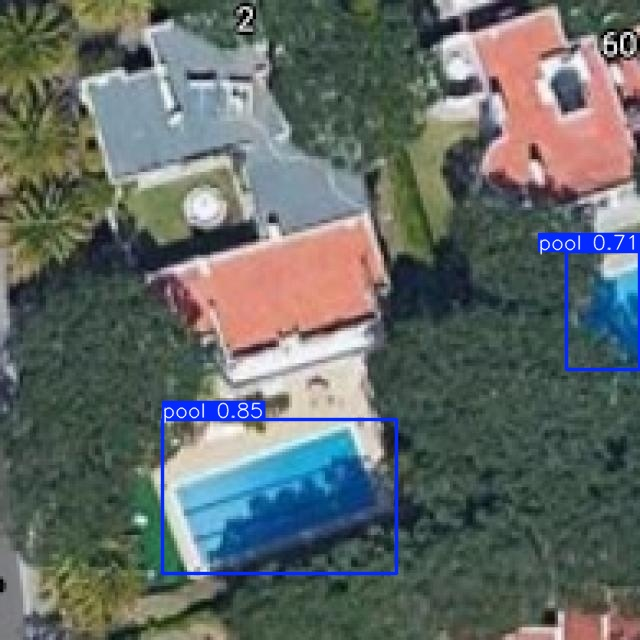

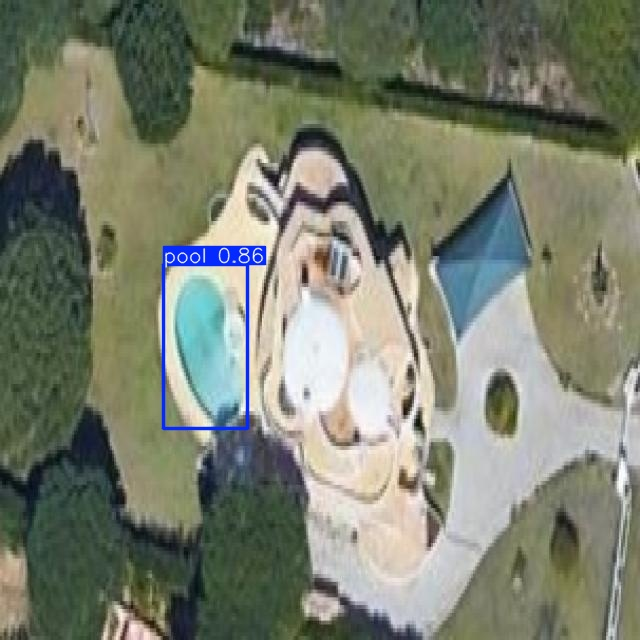

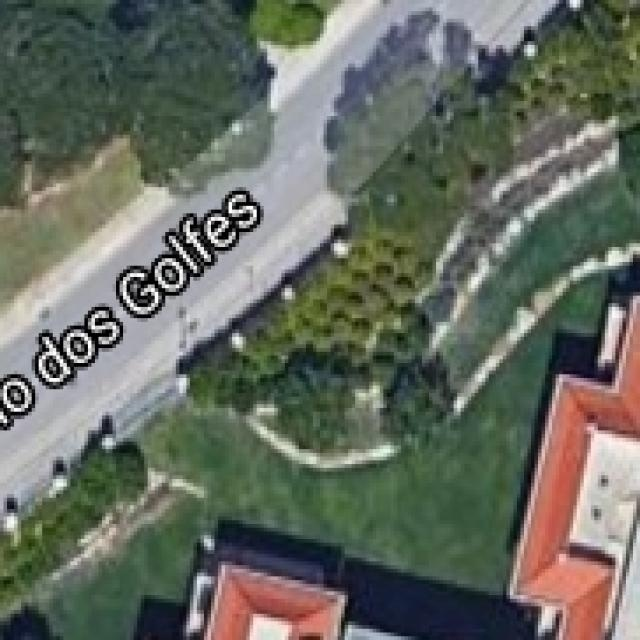

In [31]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'../runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [32]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"../runs/detect/train2/")

View the status of your deployment at: https://app.roboflow.com/spencer-kmi6v/pool-detect-cnn/2
Share your model with the world at: https://universe.roboflow.com/spencer-kmi6v/pool-detect-cnn/model/2


In [33]:
!pip install inference

^C


  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached pydantic-2.11.5-py3-none-any.whl.metadata (67 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached shapely-2.0.7-cp39-cp39-win_amd64.whl.metadata (7.1 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pytest-8.3.5-py3-none-any.whl.metadata (7.6 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using c

  DEPRECATION: Building 'wait-for2' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'wait-for2'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'paho-mqtt' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'paho-mqtt'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  You can safely remove it manually.
ERROR: Could not install packages due t

In [35]:
os.getcwd()

'C:\\Users\\SABIO\\Documents\\GitHub\\Pool-Detection-CNN\\references'

Running inference on 253_png.rf.43e5f7d372f4d2c33715923d7cd55e2a.jpg


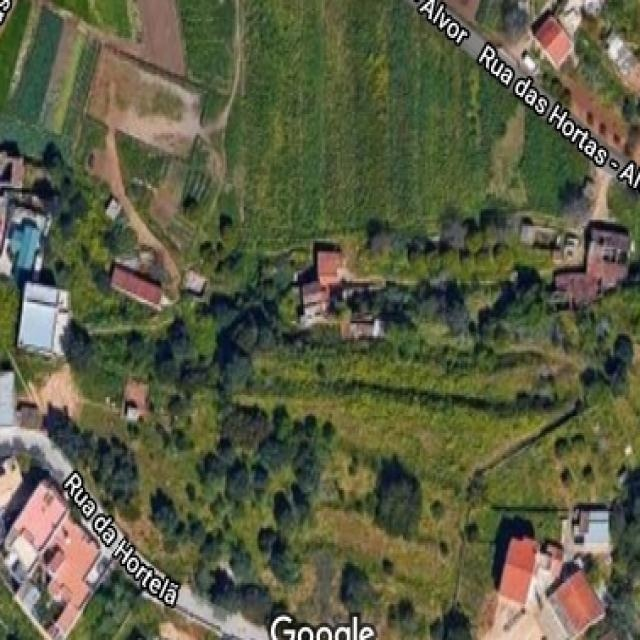

Running inference on 162_PNG.rf.e01bbd4a16290c37f63dfa86f2ec87af.jpg


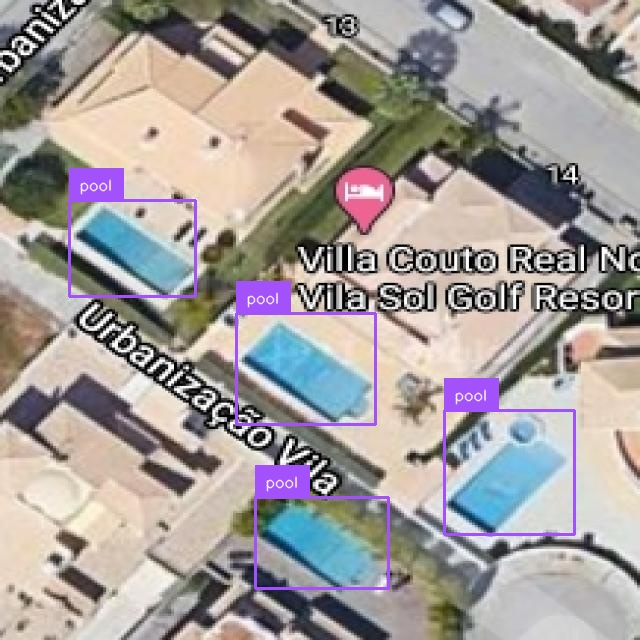

Running inference on 92_PNG.rf.30a6d3681e61742e6cec5b2a57e62d4f.jpg


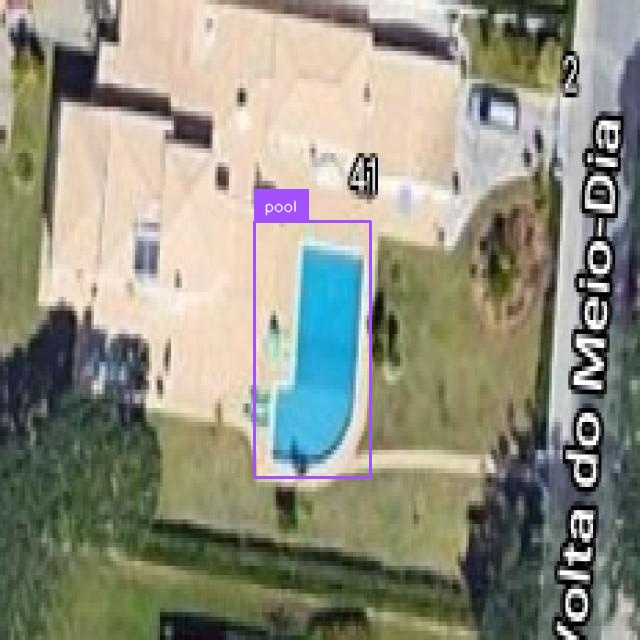

Running inference on 111_PNG.rf.9b45c26604f5c59c4219cd5543aa56be.jpg


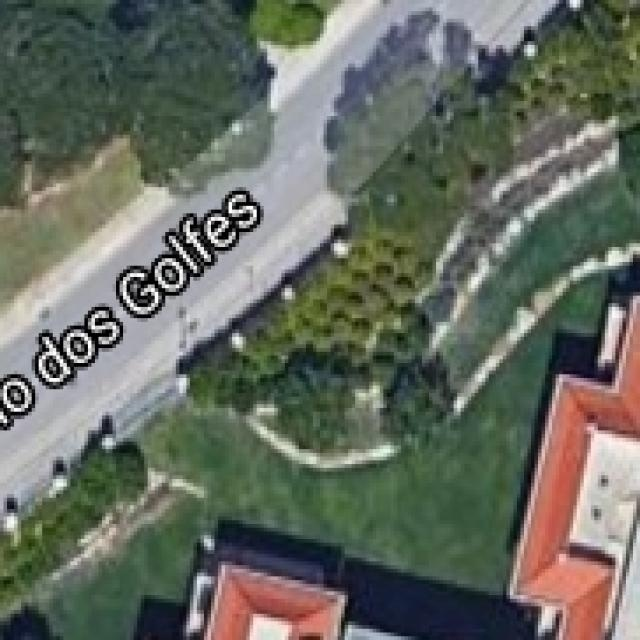

In [39]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, robo_token)

# Location of test set images
test_set_loc = dataset.location + f"/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.